In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, ks_1samp
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
import seaborn as sns
from joypy import joyplot
from scipy.stats import expon, weibull_min, gamma, kstest

In [3]:
df_claims = pd.read_csv('insurance_claims.csv')
df_claims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [4]:
#Ensure 'policy_bind_date' is in datetime format
df_claims['policy_bind_date'] = pd.to_datetime(df_claims['policy_bind_date'], errors='coerce')
# Sort by 'policy_bind_date'
df_claims = df_claims.sort_values(by='policy_bind_date').reset_index(drop=True)

In [5]:
#Calculate Interarrival Times
df_claims['interarrival_time'] = df_claims['policy_bind_date'].diff().dt.days
df_claims = df_claims.dropna(subset=['interarrival_time'])  # Remove first NaN row

Split Data into Training (70%) and Testing (30%) Chronologically

In [6]:
split_index = int(len(df_claims) * 0.7)
df_train = df_claims.iloc[:split_index]
df_test = df_claims.iloc[split_index:]

print("Training Set Size:", len(df_train))
print("Testing Set Size:", len(df_test))

Training Set Size: 699
Testing Set Size: 300


In [7]:
# Extract Interarrival Times from Training Data
train_interarrival = df_train['interarrival_time'].dropna().values

#### Descriptive Statistics

In [8]:
print("Descriptive Statistics for Interarrival Times (Training Set):")
print(f"Mean: {np.mean(train_interarrival):.2f}")
print(f"Standard Deviation: {np.std(train_interarrival):.2f}")
print(f"Skewness: {skew(train_interarrival):.2f}")
print(f"Kurtosis: {kurtosis(train_interarrival):.2f}")

Descriptive Statistics for Interarrival Times (Training Set):
Mean: 8.93
Standard Deviation: 9.08
Skewness: 2.21
Kurtosis: 7.34


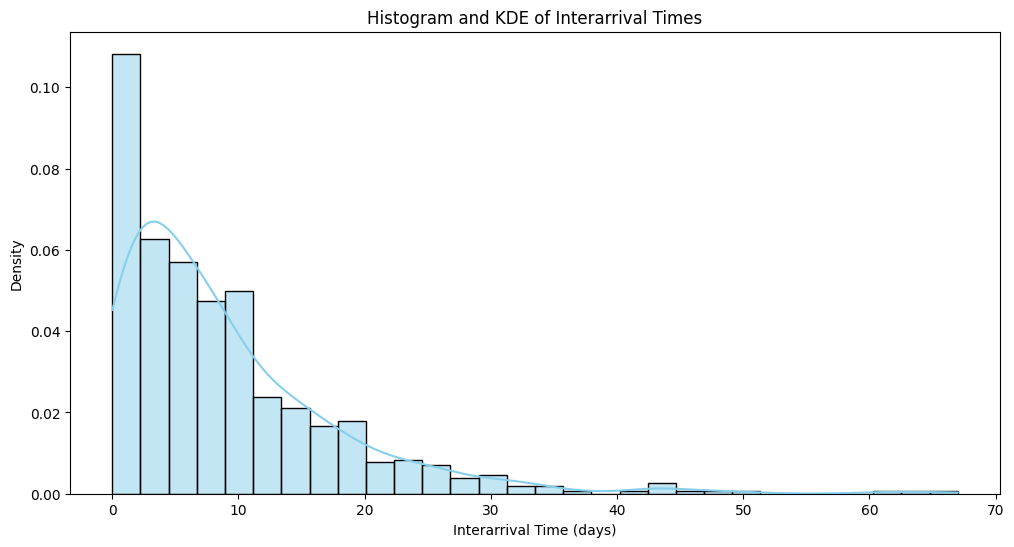

In [9]:
# Histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(train_interarrival, bins=30, kde=True, stat="density", color='skyblue', edgecolor='black')
plt.title('Histogram and KDE of Interarrival Times')
plt.xlabel('Interarrival Time (days)')
plt.ylabel('Density')
plt.show()

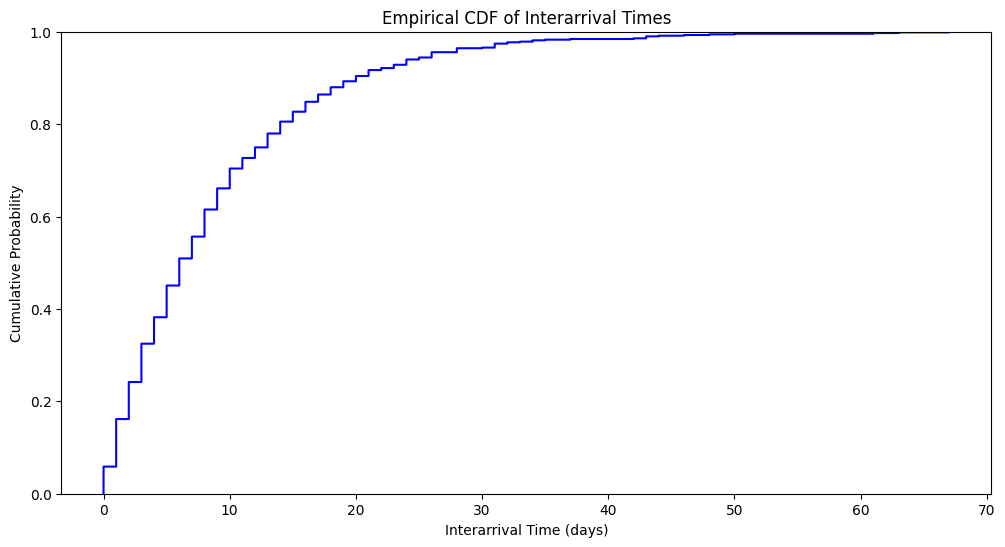

In [10]:
# Empirical CDF
plt.figure(figsize=(12, 6))
sns.ecdfplot(train_interarrival, color='blue')
plt.title('Empirical CDF of Interarrival Times')
plt.xlabel('Interarrival Time (days)')
plt.ylabel('Cumulative Probability')
plt.show()

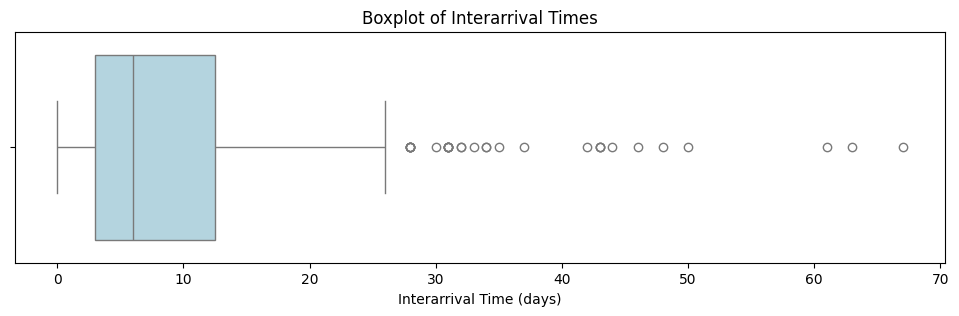

In [11]:
# Boxplot for Outliers
plt.figure(figsize=(12, 3))
sns.boxplot(x=train_interarrival, color='lightblue')
plt.title('Boxplot of Interarrival Times')
plt.xlabel('Interarrival Time (days)')
plt.show()


#### Interpretation
1. **The distribution is heavily right-skewed with a long tail.**  
2. **Most interarrival times are short (0–10 days), but some longer gaps exist (outliers).**

 **Candidate Distributions:**

1. **Exponential:** If the **event rate is constant over time**.  
2. **Weibull:** If the **rate varies over time**.  
3. **Gamma:** If we suspect a **two-parameter distribution better fits the heavy tail**.


In [12]:
#Extract Interarrival Times from the Training Dataset
train_interarrival = df_train['interarrival_time'].dropna().values

#### Fit Distributions and Perform KS Test

In [13]:
# 1. Fit Exponential Distribution
exp_params = expon.fit(train_interarrival)
exp_ks_stat, exp_p_value = kstest(train_interarrival, 'expon', args=exp_params)

# 2. Fit Weibull Distribution
weibull_params = weibull_min.fit(train_interarrival)
weibull_ks_stat, weibull_p_value = kstest(train_interarrival, 'weibull_min', args=weibull_params)

# 3. Fit Gamma Distribution
gamma_params = gamma.fit(train_interarrival)
gamma_ks_stat, gamma_p_value = kstest(train_interarrival, 'gamma', args=gamma_params)

In [14]:
# Display KS Test Results
print("\nGoodness-of-Fit Test Results (Kolmogorov-Smirnov Test):")
print(f"Exponential: KS Statistic = {exp_ks_stat:.4f}, P-Value = {exp_p_value:.4f}")
print(f"Weibull: KS Statistic = {weibull_ks_stat:.4f}, P-Value = {weibull_p_value:.4f}")
print(f"Gamma: KS Statistic = {gamma_ks_stat:.4f}, P-Value = {gamma_p_value:.4f}")


Goodness-of-Fit Test Results (Kolmogorov-Smirnov Test):
Exponential: KS Statistic = 0.0587, P-Value = 0.0156
Weibull: KS Statistic = 0.1617, P-Value = 0.0000
Gamma: KS Statistic = 0.1337, P-Value = 0.0000


In [15]:
# Determine the Best Fit Based on P-Value
best_fit = max(
    [('Exponential', exp_p_value), ('Weibull', weibull_p_value), ('Gamma', gamma_p_value)],
    key=lambda x: x[1]
)
print(f"\nBest Fit Distribution Based on KS Test: {best_fit[0]} with P-Value: {best_fit[1]:.4f}")



Best Fit Distribution Based on KS Test: Exponential with P-Value: 0.0156


**Conclusion:**
The Exponential Distribution is the best fit among the three tested distributions, even though the p-value suggests it isn't a perfect fit. However, it serves as the most appropriate model for our renewal process simulation.

Simulate Renewal Events Using Exponential Distribution

In [16]:
# Extract the rate parameter (λ) from the Exponential fit
lambda_estimate = 1 / exp_params[1]  # Scale parameter is the inverse of λ
print(f"Estimated Rate Parameter (λ): {lambda_estimate:.4f}")

Estimated Rate Parameter (λ): 0.1120


In [17]:
# Simulate synthetic interarrival times using the Exponential distribution
np.random.seed(42)
num_simulations = len(df_test)  # Simulate for the size of the test dataset
simulated_interarrival_times = np.random.exponential(scale=1/lambda_estimate, size=num_simulations)

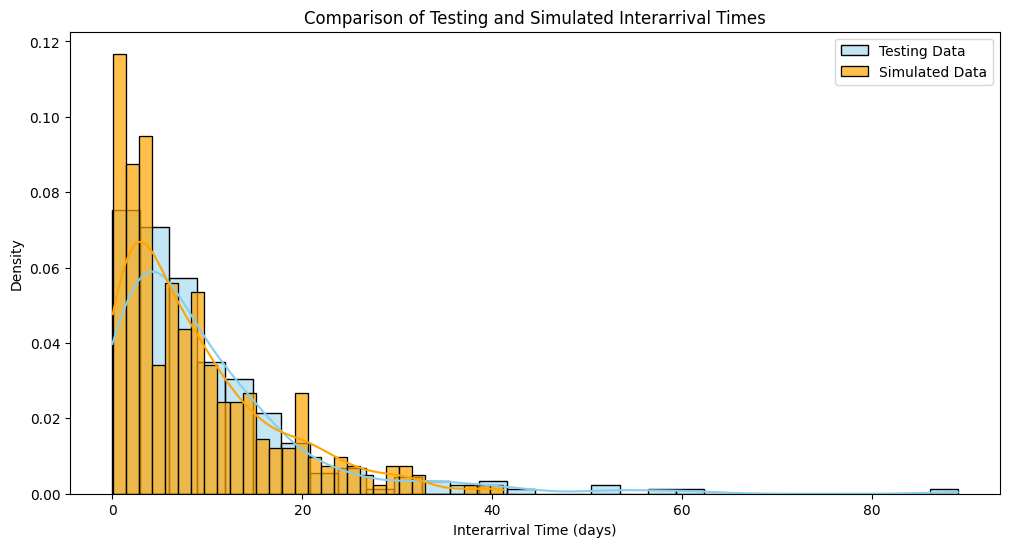

In [18]:
# Add simulated interarrival times to a DataFrame
df_simulated = pd.DataFrame({
    'simulated_interarrival_time': simulated_interarrival_times
})

#Plot Simulated vs Testing Data
plt.figure(figsize=(12, 6))
sns.histplot(df_test['interarrival_time'], bins=30, kde=True, stat="density", color='skyblue', edgecolor='black', label='Testing Data')
sns.histplot(simulated_interarrival_times, bins=30, kde=True, stat="density", color='orange', edgecolor='black', label='Simulated Data', alpha=0.7)

plt.title('Comparison of Testing and Simulated Interarrival Times')
plt.xlabel('Interarrival Time (days)')
plt.ylabel('Density')
plt.legend()
plt.show()


**Overall Shape Alignment**

**Early Interarrival Times (0–10 days):**  
- The **simulated data slightly overestimates** the frequency of **very short interarrival times**.  
- The **peak of the simulated data** is slightly **higher** than that of the **real data**.  

**Mid-Range Intervals (10–30 days):**  
- Both distributions **align reasonably well** in this range.  
- The **decay rate** of the simulated distribution **closely follows** the real data.  

**Long Intervals (>40 days):**  
- Both datasets exhibit **occasional long gaps**, although these are **less frequent and scattered**.  
- The **simulated data captures these rare events**, but **not perfectly**.  



**Joyplot Visualization for Training, Testing, and Simulated Groups**

<Figure size 1200x800 with 0 Axes>

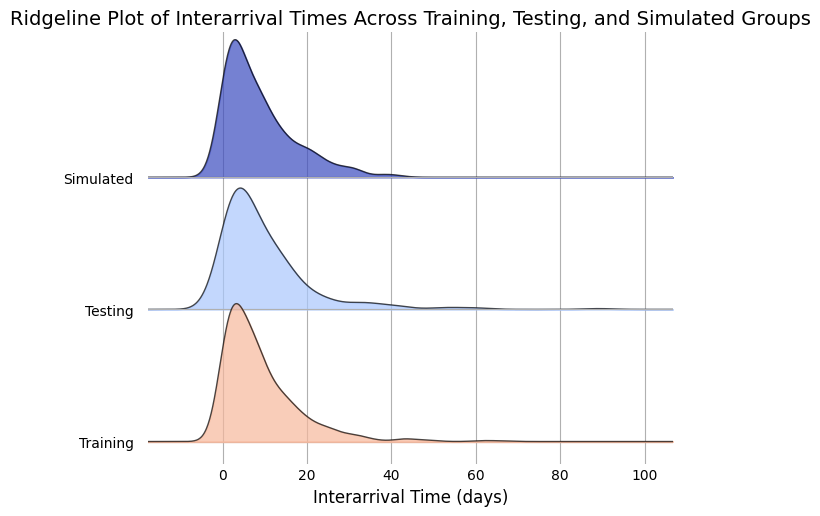

In [19]:
# Prepare the combined dataset for Joyplot
df_joyplot = pd.concat([
    pd.DataFrame({'Interarrival Time': df_train['interarrival_time'].dropna(), 'Group': 'Training'}),
    pd.DataFrame({'Interarrival Time': df_test['interarrival_time'].dropna(), 'Group': 'Testing'}),
    pd.DataFrame({'Interarrival Time': simulated_interarrival_times, 'Group': 'Simulated'})
])

# Ensure no naming conflicts
df_joyplot.reset_index(drop=True, inplace=True)

# Plot the Joyplot
plt.figure(figsize=(12, 8))
joyplot(
    data=df_joyplot,
    by='Group',
    column='Interarrival Time',
    overlap=0.5,
    alpha=0.7,
    grid=True,
    linewidth=1,
    colormap=plt.cm.coolwarm
)

# Title and labels
plt.title('Ridgeline Plot of Interarrival Times Across Training, Testing, and Simulated Groups', fontsize=14)
plt.xlabel('Interarrival Time (days)', fontsize=12)
plt.ylabel('Group', fontsize=12)

plt.show()


This Ridgeline Plot compares the distributions of Interarrival Times across the Training, Testing, and Simulated datasets. 

**1. Training Group (Bottom - Orange):**
The distribution is right-skewed, with most interarrival times concentrated between 0 and 20 days.
The density gradually tapers off towards longer interarrival times.
Very few extreme long interarrival times are observed.

**2. Testing Group (Middle - Light Blue):**
The overall shape is similar to the Training set, but the tail extends slightly further, indicating a higher occurrence of long interarrival times in the testing set.
The density curve is smoother, suggesting some variability over time.

**3. Simulated Group (Top - Dark Blue):**
The simulated data follows a similar peak and early tail structure as the Training group.
However, the tail of the distribution is shorter and less spread out compared to the Testing group.
The simulated model tends to underestimate the longer interarrival times observed in the Testing set.

 **Conclusive Remarks**

- The **Exponential Distribution** performs well for modeling short interarrival times but shows **limitations in capturing longer intervals**.  
- The **Training and Simulated groups are well-aligned**, indicating consistency in the model's reproduction of the Training data.  
- The **Testing group reveals deviations**, highlighting potential factors not captured by the current model, such as **seasonality**, **changing customer behavior**, or **external influences**.